Copyright (c) 2019 OERCompBiomed

# Unsupervised classification - prostate DCE-MRI

**DATA**

We are using TCIA PROSTATE-MRI data, originally in DICOM format, and corresponding Pathology Maps (cf. https://wiki.cancerimagingarchive.net/display/Public/PROSTATE-MRI). Data are downloaded to the ~/prj/Seili-2019/data/PROSTATE-MRI folder - as Dicom and PathologyMaps subfolders, respectiveley, and later converted to NIFTI format (cf. [prostate-mri-dcm2niix.ipynb](https://github.com/oercompbiomed/Seili-2019/blob/master/notebooks/prostate-mri-dcm2niix.ipynb). For illustration we will be using data from subject MIP-PROSTATE-01-0005 in the Seili-2019 data repository.

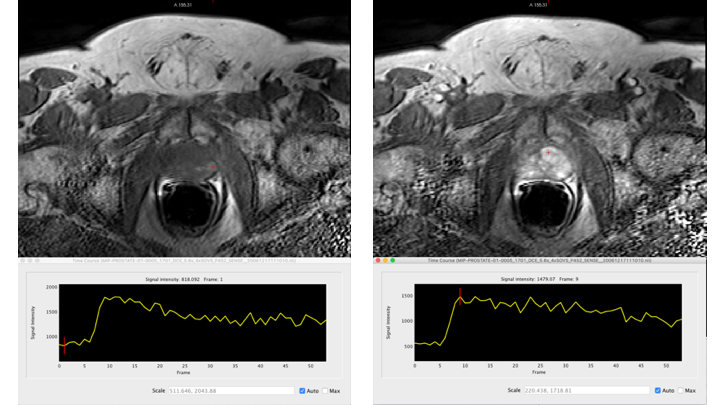

In [1]:
from IPython.display import Image
Image(filename='./assets/prostate_dce_mri_pptx.png', width=600)

**Import libraries to be used**

In [2]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import os.path as op
import pathlib
import glob
import shutil
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import cv2
from PIL import Image
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.image.image import mean_img
#import joblib
from sklearn.cluster import KMeans
from nilearn.masking import apply_mask
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
import IPython

home = os.path.expanduser('~')  # To make path to local home directory

C:\Users\arvid\Anaconda3\envs\Seili\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Read the DCE-MRI data 

In [3]:
# Using nibabel to read the prostate DCE-MRI data
fn_dce_mri = '../data/PROSTATE-MRI/Nifti/MIP-PROSTATE-01-0005/MIP-PROSTATE-01-0005_1701_DCE_5.6s_4xSOVS_P4S2_SENSE__20061217111010.nii.gz'
img = nib.load(fn_dce_mri)

In [4]:
img.get_filename()

'../data/PROSTATE-MRI/Nifti/MIP-PROSTATE-01-0005/MIP-PROSTATE-01-0005_1701_DCE_5.6s_4xSOVS_P4S2_SENSE__20061217111010.nii.gz'

## Read the binray prostate ROI mask
(manually delineated from volume 10 in the DCE-MRI series using ITK-SNAP)

In [5]:
fn_roimsk = '../data/PROSTATE-MRI/Nifti/MIP-PROSTATE-01-0005/DCE_volume_010_prostate.nii.gz'
roimsk = nib.load(fn_roimsk)
roimsk.get_filename()

'../data/PROSTATE-MRI/Nifti/MIP-PROSTATE-01-0005/DCE_volume_010_prostate.nii.gz'

**Print properties of the DCE-MRI NIFTI image**

In [6]:
print('**DCE-MRI data info:**')
print('shape of image = ', img.header.get_data_shape())
print('units = ', img.header.get_xyzt_units())
print('voxel size = ', img.header.get_zooms())
print('dtype = %s' % img.header.get_data_dtype())
data = img.get_data()
print('min = %.1f' % data.min())
print('max = %.1f' % data.max())
print('number of timepoints =', img.shape[-1])
# Collaps the singular (z-)dimension
img_data = np.uint16(data.squeeze())
print('shape of 4D img_data = ',img_data.shape)
print('dtype of 4D img_data = ',img_data.dtype)
print('img affine:', img.affine)
print(img.header)

**DCE-MRI data info:**
shape of image =  (256, 256, 12, 54)
units =  ('mm', 'sec')
voxel size =  (1.0234375, 1.0234375, 6.0, 0.005)
dtype = int16
min = 0.0
max = 10819.4
number of timepoints = 54
shape of 4D img_data =  (256, 256, 12, 54)
dtype of 4D img_data =  uint16
img affine: [[-1.01999211e+00 -8.33931416e-02  5.43488003e-02  1.47407486e+02]
 [-7.87630305e-02  9.90582883e-01  1.43563271e+00 -1.14120590e+02]
 [ 2.89265011e-02 -2.43342370e-01  5.82545805e+00  3.33688202e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 54
dim             : [  4 256 256  12  54   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.0000000e+00  1

**Print properties of the ROI mask**

In [7]:
print('**Prostate ROI mask info:**')
print('shape of image = ', roimsk.header.get_data_shape())
print('units = ', roimsk.header.get_xyzt_units())
print('voxel size = ', roimsk.header.get_zooms())
print('dtype = %s' % roimsk.header.get_data_dtype())
data_msk = roimsk.get_data()
print('min = %.1f' % data_msk.min())
print('max = %.1f' % data_msk.max())
print('roimsk affine:', roimsk.affine)
print(roimsk.header)

**Prostate ROI mask info:**
shape of image =  (256, 256, 12)
units =  ('mm', 'unknown')
voxel size =  (1.0234375, 1.0234375, 6.0)
dtype = uint16
min = 0.0
max = 2.0
roimsk affine: [[-1.01999229e+00 -8.33921586e-02  5.43007174e-02  1.47407486e+02]
 [-7.87640339e-02  9.90582847e-01  1.43563180e+00 -1.14120590e+02]
 [ 2.89182990e-02 -2.43342737e-01  5.82546245e+00  3.33688202e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256  12   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         1.0234375  1.0234375  6.         0.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope     

**Display selected slice and four different timeframes**

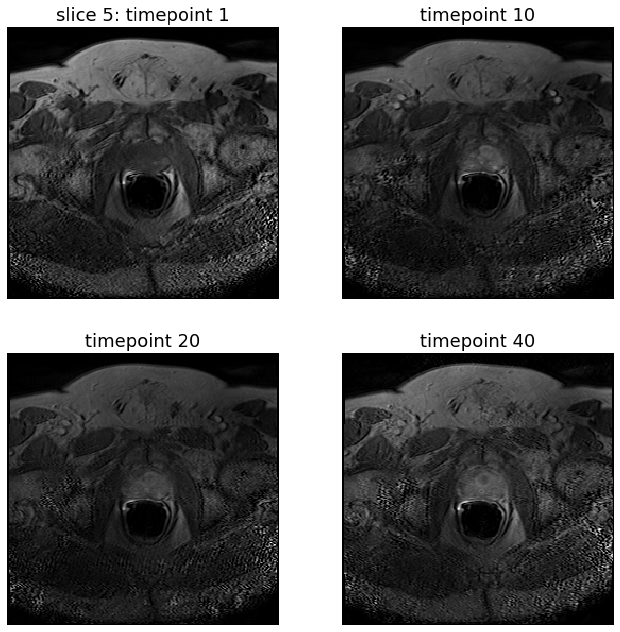

In [8]:
s = 5
t = [1, 10, 20, 40]

fig = plt.figure('Showing the DCE-MRI image', figsize = [11,11])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title('slice %d: timepoint %d' % (s, t[0]), fontsize=18)
#plt.imshow(np.fliplr(np.rot90(data[:, :, s, t[0]].squeeze(), k=3)), cmap='gray', origin='lower')  
plt.imshow(data[:, :, s, t[0]].T, cmap='gray', origin='lower')  
plt.subplot(2, 2, 2).set_axis_off(), plt.title('timepoint %d' % (t[1]), fontsize=18)
plt.imshow(np.fliplr(np.rot90(data[:, :, s, t[1]].squeeze(), k=3)), cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title('timepoint %d' % (t[2]), fontsize=18)
plt.imshow(np.fliplr(np.rot90(data[:, :, s, t[2]].squeeze(), k=3)), cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title('timepoint %d' % (t[3]), fontsize=18)
plt.imshow(np.fliplr(np.rot90(data[:, :, s, t[3]].squeeze(), k=3)), cmap='gray', origin='lower')
plt.show()

#fig.savefig('%s/prj/Seili-2019/results/prostate_dce_mri_slice%d.png' % (home, s),
#            transparent=False, dpi=300, bbox_inches="tight")

**Display K-means voxel timecourse segmentation**

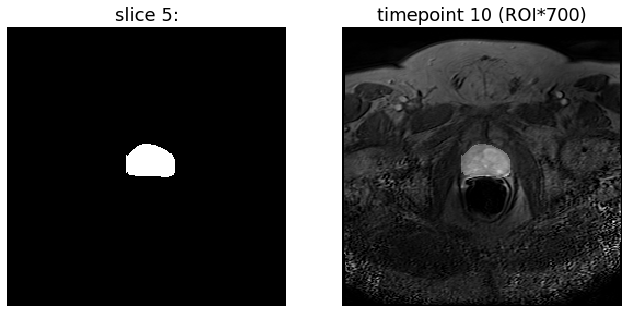

In [9]:
s = 5
t = [1, 10, 20, 40]
m = 700

a = np.fliplr(np.rot90(data_msk[:, :, s].squeeze(), k=3))
b = np.fliplr(np.rot90(data[:, :, s, t[1]].squeeze(), k=3))
c = m*a + b
fig = plt.figure('Showing the prostate ROI mask', figsize = [11,11])
plt.tight_layout
plt.subplot(1, 2, 1).set_axis_off(), plt.title('slice %d:' % (s), fontsize=18)
plt.imshow(np.fliplr(np.rot90(data_msk[:, :, s].squeeze(), k=3)), cmap='gray', origin='lower')  
plt.subplot(1, 2, 2).set_axis_off(), plt.title('timepoint %d (ROI*%d)' % (t[1], m), fontsize=18)
plt.imshow(c, cmap='gray', origin='lower')
plt.show()

#fig.savefig('%s/prj/Seili-2019/results/prostate_roi_dce_mri_slice%d.png' % (home, s),
#            transparent=False, dpi=300, bbox_inches="tight")

> **CHECK:** 
>
> - *Coordiante systems and affine transforms in medical imaging (e.g. [nibabel](http://nipy.org/nibabel/coordinate_systems.html) / [nilearn](http://nilearn.github.io/auto_examples/04_manipulating_images/plot_affine_transformation.html))*
> - *Converting from DICOM-format (privided by the scanner) to NIFTI-format for processing (e.g. [dcm2nii](https://www.nitrc.org/plugins/mwiki/index.php/dcm2nii:MainPage) og [dcm2niix](https://github.com/rordenlab/dcm2niix))*

In [10]:
# Number of voxels in the 4D image
data.flatten().size

42467328

**Find all pixel locations in the ROI for extracting a dataset X and corresponding pixel locations to a Pandas data frame (dfR)**

In [11]:
# Find voxel locations (ind_roi) corresponding to prostate ROI (value 2 inside ROI, 0 else) 
ind_roi = np.where(data_msk > 0) 
X = np.asarray(img_data[ind_roi[0][:],ind_roi[1][:],ind_roi[2][:],:]) # The DCE-MRI voxel time courses within ROI
print(X.shape)

(10778, 54)


In [12]:
min_row = min(ind_roi[0])
max_row = max(ind_roi[0])

min_col = min(ind_roi[1])
max_col = max(ind_roi[1])

min_slice = min(ind_roi[2])
max_slice = max(ind_roi[2])

min_corner = [min_row, min_col, min_slice]
max_corner = [max_row, max_col, max_slice]

print('min_corner:', min_corner)
print('max_corner:', max_corner)

min_corner: [105, 109, 0]
max_corner: [156, 152, 10]


In [13]:
dfR = pd.DataFrame(X)
dfR.head(3)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,371,487,471,568,441,474,411,487,484,574,...,644,549,739,690,633,674,590,549,685,709
1,384,365,419,460,381,409,381,406,490,555,...,558,568,652,571,558,631,593,576,595,620
2,357,349,409,411,365,376,327,379,403,511,...,530,571,650,663,609,688,582,576,666,601


In [14]:
dfR.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
10775,872,826,791,769,728,774,842,1007,1527,1755,...,2077,2058,2026,1999,1980,2134,2007,2069,2020,1988
10776,755,639,644,612,642,734,774,847,1246,1516,...,1885,1942,1901,1739,1728,1963,1928,1869,1806,1766
10777,666,671,658,666,644,736,725,845,1002,1156,...,1506,1525,1557,1359,1416,1573,1522,1470,1403,1370


In [15]:
dfR.insert(loc = len(dfR.columns),
           column = 'row',
           value = ind_roi[0])  # Row of voxel location
dfR.insert(loc = len(dfR.columns),
           column = 'col',
           value = ind_roi[1])  # Col of voxel location
dfR.insert(loc = len(dfR.columns),
           column = 'slice',
           value = ind_roi[2])  # Slice of voxel location

In [16]:
dfR.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,row,col,slice
0,371,487,471,568,441,474,411,487,484,574,...,690,633,674,590,549,685,709,105,129,6
1,384,365,419,460,381,409,381,406,490,555,...,571,558,631,593,576,595,620,105,130,6
2,357,349,409,411,365,376,327,379,403,511,...,663,609,688,582,576,666,601,105,131,6
3,341,357,376,373,463,444,354,403,414,520,...,720,574,647,617,601,598,574,105,132,6
4,338,349,371,379,354,365,381,417,392,536,...,568,487,631,460,544,601,476,105,133,6


## Unsupervised classification of ROI-restricted 4D DCE-MRI data using K-means

In [17]:
X.shape  # n x p data matrix, n = numper of samples (voxel time courses), p = feature vector dimension (time points)

(10778, 54)

In [18]:
K = 8  # Number of clusters
kmeans_model = KMeans(n_clusters=K, random_state=42)
print(kmeans_model)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)


In [19]:
# Fit the K-means model to the data
kmeans_fit = kmeans_model.fit(X)

In [20]:
print(kmeans_fit.labels_)
print('First centroid i p-dimensional feature vector space:\n', kmeans_fit.cluster_centers_[0,:])

[1 1 1 ... 4 4 2]
First centroid i p-dimensional feature vector space:
 [ 565.34485437  570.61475728  578.92271845  590.59184466  582.11883495
  568.09902913  590.5615534   674.2031068   830.44737864  966.6415534
 1020.02213592 1031.49087379 1056.16194175 1031.33902913 1076.49475728
 1084.5231068  1086.62951456 1095.49514563 1098.24271845 1136.88427184
 1142.40699029 1126.15417476 1129.93048544 1113.98640777 1132.70097087
 1133.38718447 1127.24582524 1125.50757282 1133.49514563 1128.66796117
 1130.73592233 1150.66368932 1155.41514563 1139.71650485 1155.58563107
 1152.6761165  1161.5215534  1171.77747573 1175.97009709 1178.09902913
 1177.7161165  1171.8823301  1168.16427184 1162.98834951 1160.97747573
 1142.88932039 1132.7968932  1136.59300971 1116.70174757 1179.9192233
 1169.4792233  1132.66912621 1172.23184466 1175.88349515]


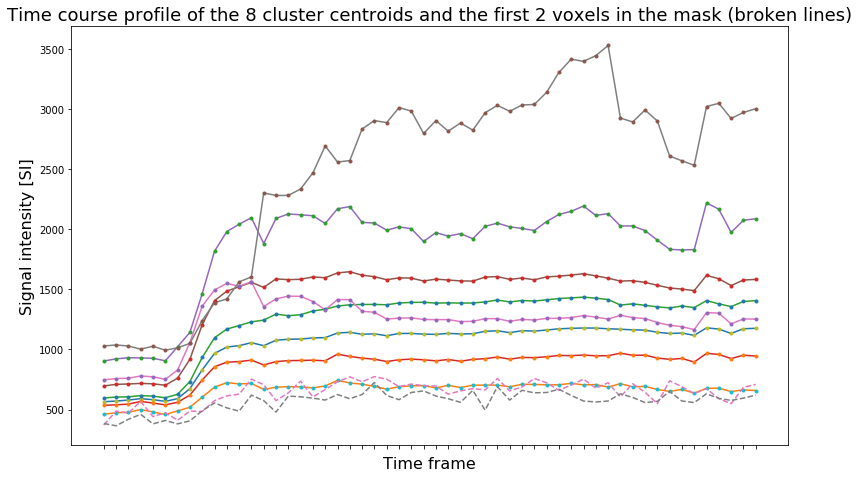

In [21]:
# Plot the cluster centroids as line plots

nv = 2

fig, ax = plt.subplots(1,1)

fig.set_size_inches(12, 7)

plt.plot(kmeans_fit.cluster_centers_.T)
plt.plot(kmeans_fit.cluster_centers_.T, '.')
plt.plot(X[:nv, :].T, '--')
plt.xlabel('Time frame', fontsize=16)
ax.set_xticks([x for x in range(X.shape[1])])
ax.set_xticklabels([], rotation='vertical', fontsize=18)
plt.ylabel('Signal intensity [SI]', fontsize=16)
#plt.xlim(0, 3)
plt.title('Time course profile of the %d cluster centroids and the first %d voxels in the mask (broken lines)' % (K, nv), fontsize=18)

plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

**Make a k-means segmented image (segmentation restricted to the ROI)**

In [22]:
kmeans_segm = 0 * data_msk.copy()
print('Size of segmented image:', kmeans_segm.shape)
print('min:', kmeans_fit.labels_.min())
print('max:', kmeans_fit.labels_.max())
print('Number of clustered samples within ROI:', len(ind_roi[0]))

Size of segmented image: (256, 256, 12)
min: 0
max: 7
Number of clustered samples within ROI: 10778


**Assign the cluster belonging to each voxel within the ROI**

In [23]:
for v in range(len(ind_roi[0])):
    kmeans_segm[ind_roi[0][v], ind_roi[1][v], ind_roi[2][v]] = kmeans_fit.labels_[v]

**Read the annotated histo prostate micrograph**

In [24]:
im_frame = Image.open('../data/PROSTATE-MRI/Nifti/MIP-PROSTATE-01-0005/' + 'histo_prostate_annotated.png')
np_frame = np.array(im_frame.getdata())

**and dsiplay the result (comparing with the DCE-MRI data time frame t[1])**

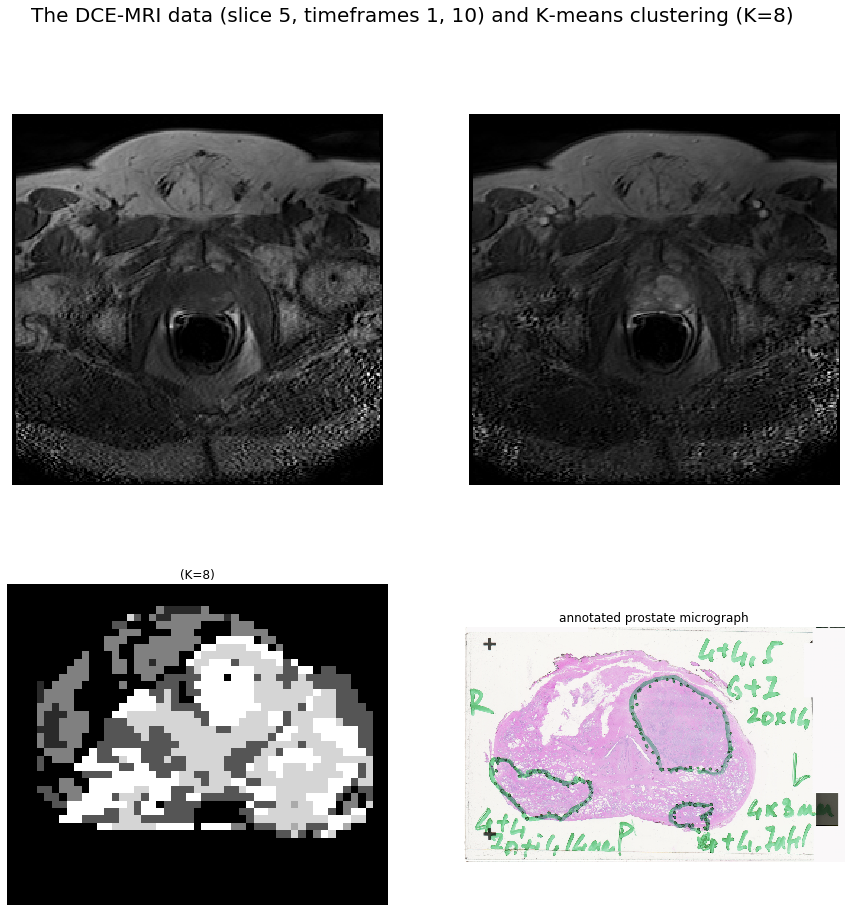

In [25]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
ax = axes.ravel()
ax[0].imshow(img_data[:, :, s, t[0]].T, cmap='gray', origin='lower')
#ax[0].set_title(chn_names[0])
ax[0].set(xlabel="")
ax[0].axis('off')
ax[1].imshow(img_data[:, :, s, t[1]].T, cmap='gray', origin='lower')
#ax[1].set_title(chn_names[0])
ax[1].set(xlabel="")
ax[1].axis('off')
ax[2].imshow(kmeans_segm[min_row:max_row, min_col:max_col, s].T, cmap='gray', origin='lower')  #'viridis'
ax[2].set_title('(K=%d)' % (K))
ax[2].axis('off')
ax[3].imshow(np.flipud(im_frame), origin='lower')
ax[3].set_title('annotated prostate micrograph')
ax[3].axis('off')
plt.suptitle('The DCE-MRI data (slice %d, timeframes %d, %d) and K-means clustering (K=%d)' % (s,t[0],t[1],K), fontsize=20) 
#plt.tight_layout
plt.show()

**Compute a 3D mean perfusion image with respect to time**

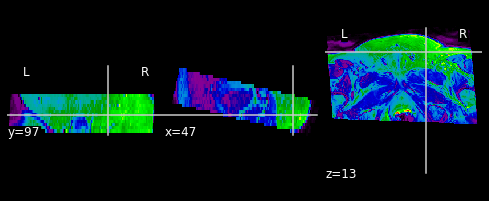

In [26]:
from nilearn.image.image import mean_img
from nilearn import plotting

# Compute the mean EPI: we do the mean along the axis 3, which is time

mean_perf = mean_img(img)

from nilearn.plotting import plot_epi, show
plot_epi(mean_perf)

display = plotting.plot_epi(mean_perf)     
display.close()

**Compute a 3D mask image derived from the 4D echo planar imaging (epi) data using [`compute_epi_mask`](https://nilearn.github.io/modules/generated/nilearn.masking.compute_epi_mask.html)**

In [27]:
from nilearn.masking import compute_epi_mask
mask_img = compute_epi_mask(img, lower_cutoff=0.05, upper_cutoff=0.2, verbose=1)

EPI mask computation


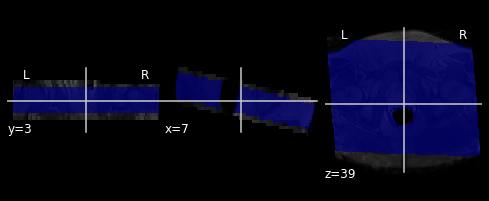

In [28]:
# Visualize it as an ROI
from nilearn.plotting import plot_roi
plot_roi(mask_img, mean_perf)

In [29]:
mask_img.shape

(256, 256, 12)

In [30]:
mask_img.get_data().shape

(256, 256, 12)

In [31]:
mask_img.get_data().max()

1

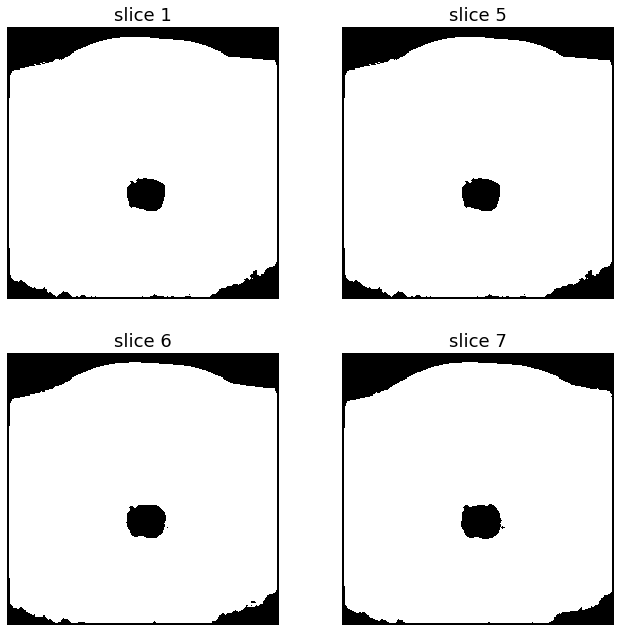

In [32]:
s = [1, 5, 6, 7]
fig = plt.figure('Showing the DCE-MRI image', figsize = [11,11])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title('slice %d' % (s[0]), fontsize=18)
plt.imshow(mask_img.get_data()[:, :, s[1]].T, cmap='gray', origin='lower')  
plt.subplot(2, 2, 2).set_axis_off(), plt.title('slice %d' % (s[1]), fontsize=18)
plt.imshow(mask_img.get_data()[:, :, s[1]].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title('slice %d' % (s[2]), fontsize=18)
plt.imshow(mask_img.get_data()[:, :, s[2]].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title('slice %d' % (s[3]), fontsize=18)
plt.imshow(mask_img.get_data()[:, :, s[3]].T, cmap='gray', origin='lower')
plt.show()

In [33]:
msk = mask_img.get_data()
mm = np.where(msk[:,:,:] == 1)
print('Number of voxels in the mask:', len(mm[0]))
print('i', mm[0][:5])
print('j', mm[1][:5])
print('k', mm[2][:5])

Number of voxels in the mask: 446410
i [2 2 2 2 2]
j [25 26 27 28 29]
k [9 9 9 9 9]


**[`apply_mask`](http://nilearn.github.io/modules/generated/nilearn.masking.apply_mask.html):**

In [34]:
from nilearn.masking import apply_mask

masked_data = apply_mask(img, mask_img)
print('shape of masked data:', masked_data.shape)
print('max SI in masked data:', masked_data.max())
print('99.5 percentile of SI:', np.percentile(masked_data, 99.5))

shape of masked data: (54, 446410)
max SI in masked data: 10759.803731918335
99.5 percentile of SI: 2126.4969611167908


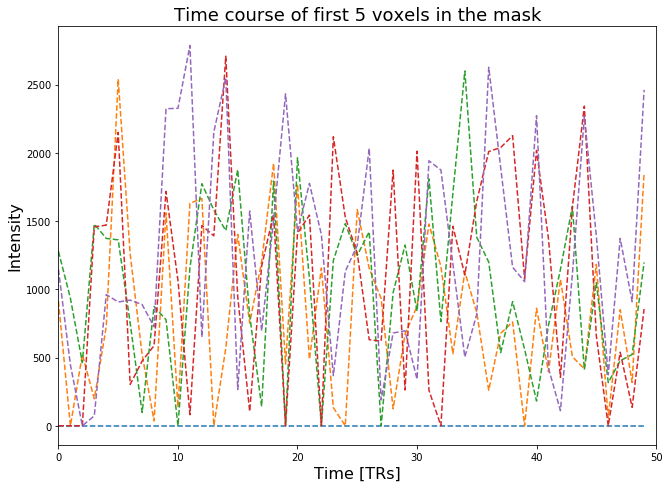

In [35]:
# masked_data shape is (timepoints, voxels). We can plot the first 50
# timepoints from nv voxels

nv = 5
# And now plot a few of these
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(masked_data[:50, :nv],'--')
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, 50)
plt.title('Time course of first %d voxels in the mask' % (nv), fontsize=18)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

### K-means clustering of time courses 

In [36]:
Y = masked_data.T   # n x p data matrix, n=samples, p = feature vector dimension
K = 32  # Number of clusters (if K>10 it will take a LOOONG TIME)
print(Y.shape)
kmeans_model = KMeans(n_clusters=K, random_state=42)
print(kmeans_model)

(446410, 54)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=32, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)


In [37]:
kmeans_fit = kmeans_model.fit(Y)

In [38]:
print('The list of cluster assignments to the enumerated voxels (n=%d):\n' % (len(mm[0])), kmeans_fit.labels_)
print('The coordinates of first kmeans.cluster_center (centroid time course):\n', kmeans_fit.cluster_centers_[0,:])

The list of cluster assignments to the enumerated voxels (n=446410):
 [ 5  0 12 ... 19 19 19]
The coordinates of first kmeans.cluster_center (centroid time course):
 [ 693.57862017  669.65305512  653.98302012  740.252488    795.8664613
  827.26357926  726.73212353  712.57731669  791.59996603  855.28190263
  799.60742393  738.33878854  762.75271863  852.81846837  977.02395954
  877.08545677  741.95268982  919.53172566 1962.40717269  733.93226648
  882.09962595  799.52530946  892.52989305  967.38977067  842.47118011
  792.52742742  804.84027692  848.83980595  871.07294844  860.02206877
  791.87396907  841.80562067  861.91070171  851.77777544  790.60508434
  775.65160618  848.03076227  782.55267957  786.4984962   746.40243003
  790.42616122  790.86180012  719.01682029  768.16622347  740.00182276
  762.72678775  760.16135866  740.83852605  735.86757501  696.14404925
  702.70542802  729.5845211   675.92227923  692.25182312]


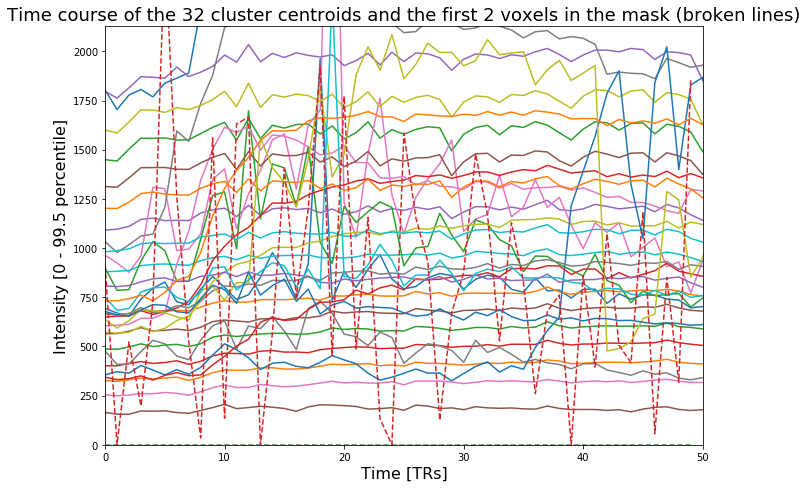

In [39]:
nv = 2

plt.figure(figsize=(10, 7))

plt.plot(kmeans_fit.cluster_centers_.T)
plt.plot(masked_data[:50, :nv], '--')
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity [0 - 99.5 percentile]', fontsize=16)
plt.xlim(0, 50)
plt.ylim(0, np.percentile(masked_data, 99.5))
plt.title('Time course of the %d cluster centroids and the first %d voxels in the mask (broken lines)' % (K, nv), fontsize=18)

plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

In [40]:
kmeans_segm = 0 * mask_img.get_data().copy()
print(kmeans_segm.shape)

for v in range(len(mm[0])):
    kmeans_segm[mm[0][v], mm[1][v], mm[2][v]] = kmeans_fit.labels_[v]

(256, 256, 12)


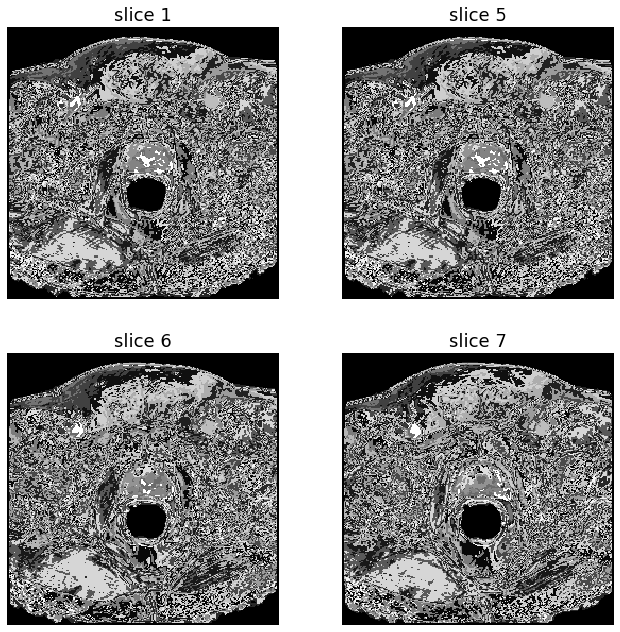

In [41]:
s = [1, 5, 6, 7]
fig = plt.figure('Showing the Kmeans clustered perfusion image', figsize = [11,11])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title('slice %d' % (s[0]), fontsize=18)
plt.imshow(kmeans_segm[:, :, s[1]].T, cmap='gray', origin='lower')  
plt.subplot(2, 2, 2).set_axis_off(), plt.title('slice %d' % (s[1]), fontsize=18)
plt.imshow(kmeans_segm[:, :, s[1]].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title('slice %d' % (s[2]), fontsize=18)
plt.imshow(kmeans_segm[:, :, s[2]].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title('slice %d' % (s[3]), fontsize=18)
plt.imshow(kmeans_segm[:, :, s[3]].T, cmap='gray', origin='lower')
plt.show()

**K-means "smoothed" data**

In [42]:
data_smooth = data.copy()

for v in range(len(mm[0])):
    data_smooth[mm[0][v], mm[1][v], mm[2][v]] = kmeans_fit.cluster_centers_[kmeans_fit.labels_[v],:]

data_smooth.shape

(256, 256, 12, 54)

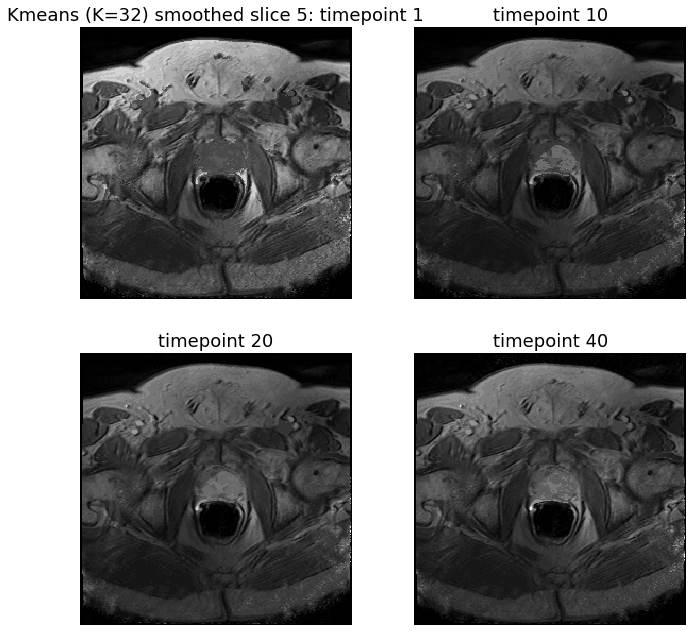

In [43]:
s = 5
t = [1, 10, 20, 40]
fig = plt.figure('Showing the Kmeans-smoothed DCE-MRI data', figsize = [11,11])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title('Kmeans (K=%d) smoothed slice %d: timepoint %d' % (K, s, t[0]), fontsize=18)
plt.imshow(data_smooth[:, :, s, t[0]].T, cmap='gray', origin='lower')  
plt.subplot(2, 2, 2).set_axis_off(), plt.title('timepoint %d' % (t[1]), fontsize=18)
plt.imshow(data_smooth[:, :, s, t[1]].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title('timepoint %d' % (t[2]), fontsize=18)
plt.imshow(data_smooth[:, :, s, t[2]].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title('timepoint %d' % (t[3]), fontsize=18)
plt.imshow(data_smooth[:, :, s, t[3]].T, cmap='gray', origin='lower')
plt.show()

#### Make a new NIFTI image by passing the new smoothed data and keeping the [affine and header](https://nipy.org/nibabel/nifti_images.html) from the original image

In [44]:
img_smooth = nib.Nifti1Image(data_smooth, img.affine, img.header)

**Display the original noisy time course and the assigned (smoothed) cluster centroid time course (for first 3 time courses)**

random voxels in the mask: [128037 267336]
their voxel locations:
i: [ 76 152]
j: [176 133]
k: [2 8]


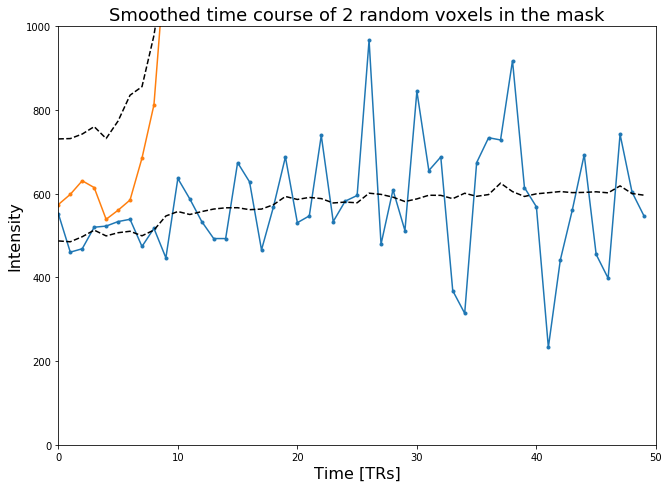

In [45]:
import random
from numpy.random import RandomState

#mask_img_smooth = compute_epi_mask(img_smooth)
masked_data_smooth = apply_mask(img_smooth, mask_img)

# masked_data shape is (timepoints, voxels). We can plot the first 50
# timepoints from two voxels

nv = 2

# seed the random number generator with a fixed value
prng = RandomState(1)
voxlist = prng.randint(0, len(mm[0]), size=nv)
# voxlist = random.sample(range(len(mm[0])), nv)

print('random voxels in the mask:', voxlist)
print('their voxel locations:')
print('i:', mm[0][voxlist])
print('j:', mm[1][voxlist])
print('k:', mm[2][voxlist])

# And now plot a few of these
plt.figure(figsize=(10, 7))
plt.plot(masked_data[:50, voxlist],'.-')
plt.plot(masked_data_smooth[:50, voxlist],'--', color="black")
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, 50)
plt.ylim(0, 1000)
plt.title('Smoothed time course of %d random voxels in the mask' % (nv), fontsize=18)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

###  Make a new smoothed nifti image and save it to disk, e.g.  in ~/prj/Seili-2019/data

In [46]:
mylocaldata = '%s/prj/Seili-2019/data' % (home)
affine = img.affine

img_orig = nib.Nifti1Image(data, affine)
img_smooth = nib.Nifti1Image(data_smooth, affine)

img_orig_name = 'prostate_dce_mri'
img_smooth_name = 'prostate_dce_mri_smoothed'
fn_orig = '%s/%s.nii.gz' % (mylocaldata, img_orig_name)
fn_smooth = '%s/%s.nii.gz' % (mylocaldata, img_smooth_name)

nib.save(img_orig, fn_orig)
nib.save(img_smooth, fn_smooth)